# imports

In [1]:
import pickle
import pandas as pd
import seaborn
import plotly.express as px

from joblib import Memory
from matplotlib import pyplot as plt
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from pyriemann.utils.mean import mean_riemann
from brainspace.gradient import GradientMaps

from gradecc.compute.conn_mat.center import center_cmat
# Dan's

from gradecc.load_data import Timeseries
# loads data from file to pd.df

from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
import nibabel
from surfplot import Plot


SUBJECTS_INT = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 38, 40, 41, 44, 45, 46]
EPOCHS = ['baseline', 'early', 'late']
EPOCH_REF = 'baseline'

APR='pca'
RANS=0

# utils

In [2]:
def dump(a, fname):
    with open(fname+'.pkl', 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(fname):
    with open(fname+'.pkl', 'rb') as handle:
        return pickle.load(handle)

mem = Memory('.')

# timeseries

In [28]:
sample_ts = Timeseries(subject=2, epoch='baseline')
sample_ts.load()
sample_ts.data

,7Networks_LH_Vis_1,7Networks_LH_Vis_2,7Networks_LH_Vis_3,7Networks_LH_Vis_4,7Networks_LH_Vis_5,7Networks_LH_Vis_6,7Networks_LH_Vis_7,7Networks_LH_Vis_8,7Networks_LH_Vis_9,7Networks_LH_Vis_10,...,Right VIIIa,Left VIIIb,Vermis VIIIb,Right VIIIb,Left IX,Vermis IX,Right IX,Left X,Vermis X,Right X
3,0.619059,0.212399,-0.397736,-0.019531,-0.375093,-0.260682,0.813853,-0.097351,-0.211968,0.341829,...,0.787102,0.045657,0.692766,0.116574,-0.694965,-0.669235,0.321611,-0.714039,0.645568,-0.548769
4,0.925779,-0.954917,-0.258214,-0.649791,0.379977,-0.625451,-0.145867,0.184408,-0.680507,-0.382208,...,0.128971,0.148791,0.152312,-1.159273,0.528155,0.635899,-1.205409,0.676500,0.085890,0.047503
5,0.626875,-0.989889,-0.161264,-1.004715,0.412673,-0.759415,-0.606122,-0.048508,-0.729473,-0.758798,...,-1.041844,-0.619600,-1.005859,-0.998181,-0.595157,-1.101287,-1.257779,-0.985447,-0.847289,-0.228887
6,0.291048,-0.183669,-0.235433,-0.797872,-0.397722,-0.705493,-0.242141,-0.720461,-0.297353,-0.457756,...,-0.859729,0.554819,-0.492801,1.298689,0.689845,0.005797,-0.190183,0.610956,-0.000497,0.721711
7,0.399648,0.237355,-0.366008,-0.403004,-1.052488,-0.647728,0.201340,-1.234412,0.199633,0.074474,...,0.275050,-1.430377,1.747600,-0.308219,-0.489006,1.022842,0.992858,-0.392210,0.574385,-0.375016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,-0.146590,1.521479,0.649142,-0.271221,0.141444,1.108605,-0.443911,-0.021621,-0.006362,-0.437139,...,-0.292085,1.374837,0.820518,0.514357,1.016304,0.880243,1.890717,1.528671,-0.255163,0.325893
215,-0.205213,-0.125841,-0.605073,-0.945500,-0.438729,0.360575,-0.533365,-0.923990,-0.418029,-0.167742,...,0.841928,0.819967,-0.379003,0.564662,1.756883,2.004688,2.105934,0.657847,0.748752,1.317683
216,-0.054129,-1.571816,-1.382739,-1.249235,-0.832187,-0.486080,-0.443039,-1.407017,-0.874403,0.214144,...,0.781670,-0.139723,-0.469562,0.278206,0.778243,1.449812,1.326075,0.214427,0.605848,0.233798
217,-0.143634,-0.984511,-0.740617,-0.905064,-0.714287,-0.829367,-0.137792,-0.784766,-0.641033,-0.051187,...,-0.257333,-1.375125,0.183924,-1.309316,-0.088991,0.827189,0.126521,0.434710,0.625600,-0.600772


# conn mat

In [6]:
def cmat(ts: Timeseries, fill_diag=False, kind='covariance') -> np.ndarray:
    if ts.data is None: ts.load()
    conn_measure = ConnectivityMeasure(kind=kind)
    cmat = conn_measure.fit_transform([ts.data.to_numpy()])[0]
    if fill_diag:   np.fill_diagonal(cmat, 0)
    return cmat

In [7]:
cmat(Timeseries(1, 'baseline'))

array([[ 1.00787953,  0.23300753,  0.50633092, ...,  0.04168037,
        -0.12909226,  0.032568  ],
       [ 0.23300753,  1.00791613,  0.23761153, ...,  0.06854963,
        -0.1366801 ,  0.1801675 ],
       [ 0.50633092,  0.23761153,  0.9992181 , ...,  0.03359876,
         0.02517184,  0.11424387],
       ...,
       [ 0.04168037,  0.06854963,  0.03359876, ...,  1.00198158,
         0.13651203,  0.20046535],
       [-0.12909226, -0.1366801 ,  0.02517184, ...,  0.13651203,
         1.00459698,  0.047801  ],
       [ 0.032568  ,  0.1801675 ,  0.11424387, ...,  0.20046535,
         0.047801  ,  1.00519787]])

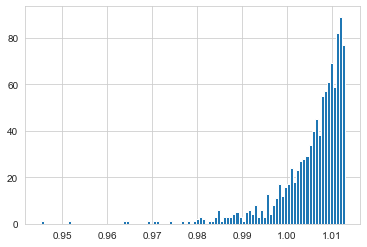

In [8]:
plt.hist(np.diag(_), bins=100)
plt.show()

# center mat
dump load

In [11]:
print(SUBJECTS_INT)

[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 38, 40, 41, 44, 45, 46]


In [12]:
EPOCHS

['baseline', 'early', 'late']

In [13]:
# grand_mean = mean_riemann(
#         np.stack([cmat(Timeseries(s, e))
#                   for e in EPOCHS for s in SUBJECTS_INT]),
#     maxiter=5)
#
# dump(grand_mean, 'grand_mean_iter5')
grand_mean = load('grand_mean_iter5')

In [14]:
grand_mean

array([[0.16378138, 0.01275667, 0.0134736 , ..., 0.00386107, 0.00217978,
        0.00450187],
       [0.01275667, 0.15615674, 0.0224449 , ..., 0.00591451, 0.00255782,
        0.00573476],
       [0.0134736 , 0.0224449 , 0.16030768, ..., 0.00596199, 0.00261473,
        0.00506538],
       ...,
       [0.00386107, 0.00591451, 0.00596199, ..., 0.51607051, 0.06587699,
        0.14030197],
       [0.00217978, 0.00255782, 0.00261473, ..., 0.06587699, 0.5348349 ,
        0.05112269],
       [0.00450187, 0.00573476, 0.00506538, ..., 0.14030197, 0.05112269,
        0.51443634]])

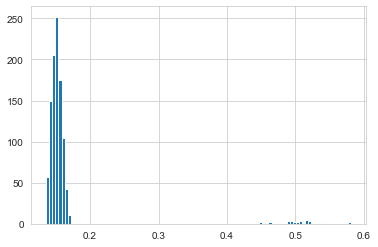

In [15]:
plt.hist(np.diag(grand_mean), bins=100)
plt.show()

In [16]:
@mem.cache
def subj_mean(subject):
    return  mean_riemann(np.stack([
        cmat(Timeseries(subject, e)) for e in EPOCHS]), maxiter=5)

---

In [17]:
c1 = cmat(Timeseries(1, 'early'))
c1

array([[ 1.21933276,  0.7151146 ,  0.55243186, ...,  0.26788957,
        -0.01723554,  0.16986816],
       [ 0.7151146 ,  1.25696243,  0.68387336, ...,  0.25763842,
        -0.05759605,  0.24000709],
       [ 0.55243186,  0.68387336,  1.17811635, ...,  0.30843265,
         0.17739462,  0.21476946],
       ...,
       [ 0.26788957,  0.25763842,  0.30843265, ...,  0.98947952,
         0.19379536,  0.51059608],
       [-0.01723554, -0.05759605,  0.17739462, ...,  0.19379536,
         1.15014879,  0.16395357],
       [ 0.16986816,  0.24000709,  0.21476946, ...,  0.51059608,
         0.16395357,  1.06348801]])

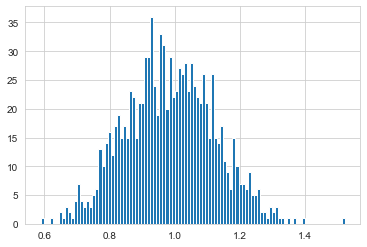

In [18]:
plt.hist(np.diag(_), bins=100)
plt.show()

In [19]:
center_cmat(c1, subj_mean(1), grand_mean)

array([[0.39898198, 0.1640771 , 0.12689111, ..., 0.06537281, 0.01570356,
        0.04411934],
       [0.1640771 , 0.37573711, 0.17997445, ..., 0.06698158, 0.03099819,
        0.06633237],
       [0.12689111, 0.17997445, 0.39024098, ..., 0.08139321, 0.06058   ,
        0.04809958],
       ...,
       [0.06537281, 0.06698158, 0.08139321, ..., 0.62868608, 0.126743  ,
        0.25494809],
       [0.01570356, 0.03099819, 0.06058   , ..., 0.126743  , 0.72507699,
        0.08844958],
       [0.04411934, 0.06633237, 0.04809958, ..., 0.25494809, 0.08844958,
        0.69187942]])

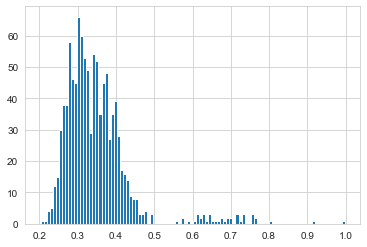

In [20]:
plt.hist(np.diag(_), bins=100)
plt.show()

## ref mat

In [21]:
EPOCH_REF

'baseline'

In [22]:
# ref_cmat = mean_riemann(
#     np.stack([cmat(Timeseries(s, EPOCH_REF)) for s in SUBJECTS_INT]),
#     maxiter=5)
#
# dump(ref_cmat, 'ref_cmat')
ref_cmat = load('ref_cmat')

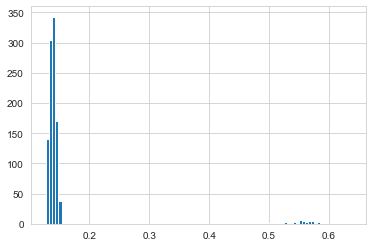

In [23]:
plt.hist(np.diag(ref_cmat), bins=100)
plt.show()

# grads
## ref grads
we need a reference gradient to align others to it.

In [24]:
APR

'pca'

if you don't apply cosine kernel while making affinity mat, you get way skewed gradient values.

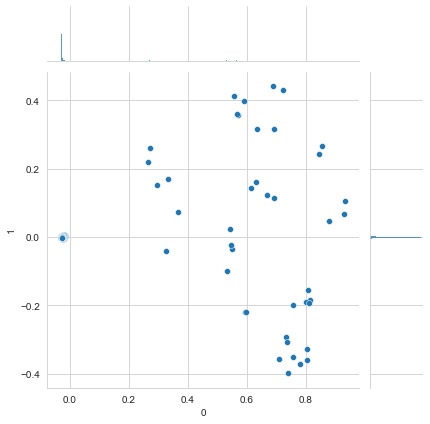

In [25]:
gref_nokernel = GradientMaps(random_state=RANS, approach=APR)
gref_nokernel.fit(ref_cmat)
seaborn.jointplot(data=pd.DataFrame(gref_nokernel.gradients_), x=0, y=1)

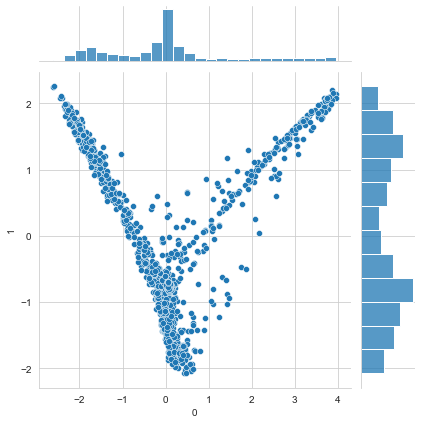

In [29]:
gref = GradientMaps(random_state=RANS, approach=APR, kernel='cosine')
gref.fit(ref_cmat)
seaborn.jointplot(data=pd.DataFrame(gref.gradients_), x=0, y=1)

# average gradient values

## no centering

In [ ]:
# g = GradientMaps(random_state=RANS, approach=APR, alignment='procrustes',
#                  # kernel='cosine'
#                  )
# g.fit([cmat(Timeseries(s, e)) for e in EPOCHS for s in SUBJECTS_INT],
#           reference=gref.gradients_)
#
# assert len(g.aligned_) == len(EPOCHS) * len(SUBJECTS_INT)
# np.stack(g.aligned_).shape

In [ ]:
# len(g.aligned_)//3 == len(SUBJECTS_INT)

In [ ]:
# [(s, e) for e in EPOCHS for s in [1, 2]]

In [35]:
# gb = np.stack(g.aligned_[:len(SUBJECTS_INT)])
# gb.mean(axis=0)

In [36]:
# plt.hist(_[:, 0], bins=100)
# plt.show()
# plt.hist(_[:, 1], bins=100)
# plt.show()

## average centered

In [30]:
gref.gradients_.max(0)

array([3.96394741, 2.258423  , 3.1507681 , 2.59422388, 1.860547  ,
       1.41994256, 1.72465702, 1.87724559, 1.19354027, 1.29901002])

In [31]:
gref.gradients_.min(0)

array([-2.61766522, -2.07812212, -2.10691644, -2.05076532, -1.65081259,
       -1.40442489, -1.36284832, -1.38188356, -1.12713699, -0.9836639 ])

In [32]:
g = GradientMaps(random_state=RANS, approach=APR, alignment='procrustes', kernel='cosine')
g.fit([center_cmat(cmat(Timeseries(s, e)), subj_mean(s), grand_mean)
       for e in EPOCHS for s in SUBJECTS_INT],
          reference=gref.gradients_)

assert len(g.aligned_) == len(EPOCHS)*len(SUBJECTS_INT)
np.stack(g.aligned_).shape

(114, 1040, 10)

In [48]:
g_epochs = np.stack(subjects.mean(axis=0) for subjects in
                    np.split(np.array(g.aligned_), len(EPOCHS)))

In [49]:
g_epochs.shape

(3, 1040, 10)

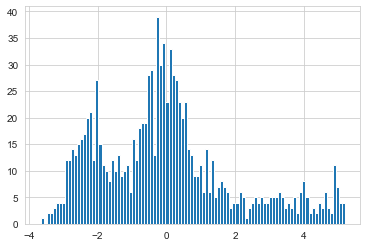

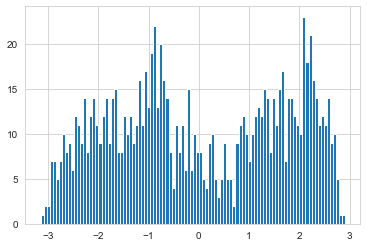

In [52]:
plt.hist(g_epochs[0, :, 0], bins=100)
plt.show()
plt.hist(g_epochs[0, :, 1], bins=100)
plt.show()

In [54]:
# e.g. top ten gradient values for epoch 'late'
g_epochs[2].shape

(1040, 10)

In [126]:
df_baseline = pd.DataFrame(g_epochs[0], index=sample_ts.data.columns.tolist()
                           ).rename_axis('region').reset_index()

## hue network

In [127]:
r = df_baseline.region
r = r.apply(lambda x: x.split(' ')[0]+'SubC' if ' ' in x   # subcortical regions
            else x[10:].split('_')[1]+'Cort')    # cortical regions
r = r.rename('label')

In [128]:
df_baseline = pd.concat([r, df_baseline], axis=1)
df_baseline

,label,region,0,1,2,3,4,5,6,7,8,9
0,VisCort,7Networks_LH_Vis_1,0.752718,0.176407,0.680963,0.083991,0.040516,-0.164206,0.634663,-0.235108,0.190004,-0.267723
1,VisCort,7Networks_LH_Vis_2,1.386640,1.247141,0.796006,-0.195546,0.033240,-0.280784,0.533358,-0.211525,0.702615,0.165431
2,VisCort,7Networks_LH_Vis_3,1.524403,1.176610,0.645935,-0.195132,0.124874,-0.141566,0.787120,-0.219161,0.618986,-0.028174
3,VisCort,7Networks_LH_Vis_4,3.844790,2.309428,0.469066,-0.203450,-0.237147,-0.417785,0.753536,-0.061446,0.554675,0.175892
4,VisCort,7Networks_LH_Vis_5,1.435111,0.271694,-0.040040,0.250803,0.165145,0.310672,0.584152,-0.278210,0.192572,-0.393474
...,...,...,...,...,...,...,...,...,...,...,...,...
1035,VermisSubC,Vermis IX,0.334642,-0.912915,2.668205,2.025409,1.487541,0.229632,-0.224628,-0.064891,-0.126478,0.225963
1036,RightSubC,Right IX,0.145214,-1.048263,2.933330,2.273280,1.807127,0.274032,-0.252895,-0.179310,-0.174607,0.163072
1037,LeftSubC,Left X,0.270025,-0.690291,2.557238,1.883028,1.609901,0.254211,-0.248852,0.001519,-0.201813,0.065929
1038,VermisSubC,Vermis X,0.356602,-1.070557,2.205049,1.721528,1.279152,0.185937,-0.214658,-0.105277,-0.077204,0.136949


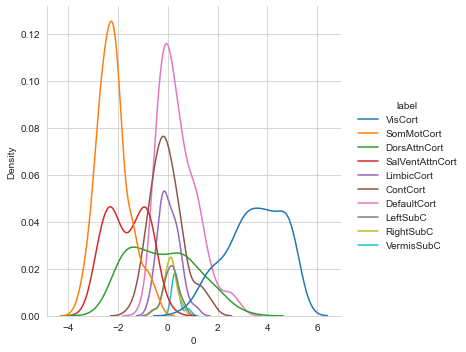

In [129]:
seaborn.displot(df_baseline, x=0, hue='label', kind='kde')

In [132]:
fig = px.scatter_3d(df_baseline, x=0, y=1, z=2, color='label', opacity=.4)
fig.update_traces(marker_size=3)
fig.show()

# plot on brain

In [133]:
fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


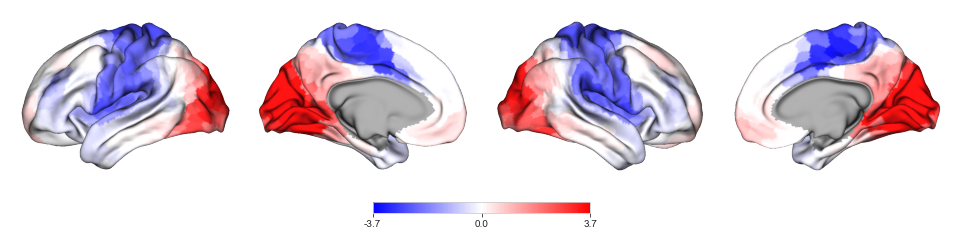

In [134]:
data = df_baseline[0]
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
figure = p.build()

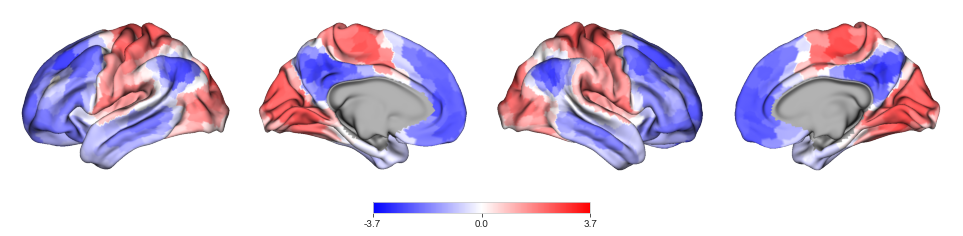

In [135]:
data = df_baseline[1]
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
_ = p.build()

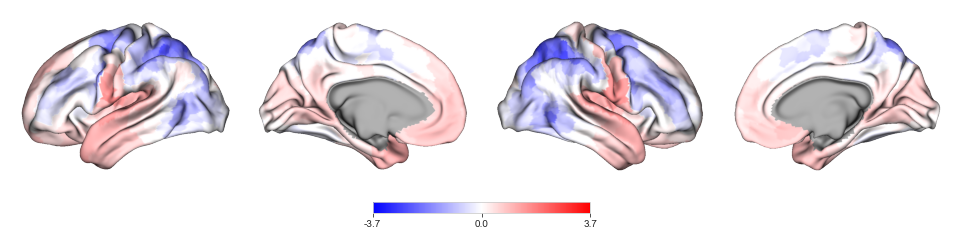

In [136]:
data = df_baseline[3]
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
_ = p.build()